## 190071B
## Bandara D.R.K.W.M.S.D

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Question 1,2
s = open('templeSparseRing/templeSR_par.txt','r')
assert s is not None
n = int(s.readline())
#first img
l = s.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))
#second img 
l = s.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))


im1 = cv.imread('templeSparseRing/'+ im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread('templeSparseRing/'+ im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None


P1 = K1 @ np.hstack((R1,t1)) # P =K*[R|t]
P2 = K2 @ np.hstack((R2,t2)) # P =K*[R|t]

print("P1 = ", P1)
print("P2 = ", P2)

P1 =  [[ 4.80251845e+01  1.44011271e+03 -5.71648932e+02  7.53293366e+01]
 [ 1.53577034e+03 -6.41434324e+01 -1.63127843e+02  1.85810055e+02]
 [ 4.88387837e-02 -1.81568392e-01 -9.82164799e-01  6.14604846e-01]]
P2 =  [[-1.55882371e+02  1.44377186e+03 -5.42436214e+02  6.81806220e+01]
 [ 1.34928131e+03 -8.41979541e+01 -7.49443961e+02  1.99929996e+02]
 [-3.40999743e-01 -1.74474039e-01 -9.23730472e-01  6.00850565e-01]]


F = [[-2.87071497e-04 -3.96261289e-02  2.94221686e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


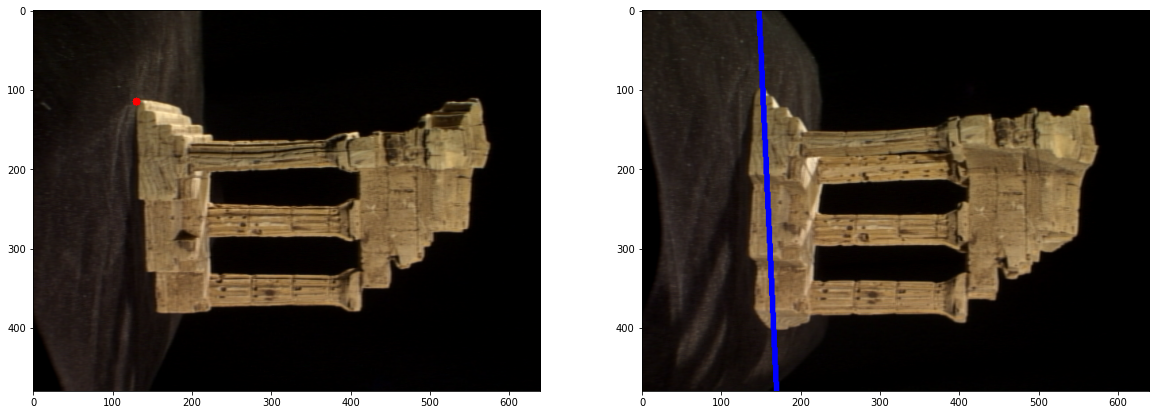

In [6]:
#Question 3
from scipy.linalg import null_space
def skew(x):
    x = x.ravel()
    return np.array([[0,-x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]])
 
C = null_space(P1)
C=C*np.sign(C[0,0])
e2 = P2 @ C
e2x = skew(e2)

F=e2x @ P2 @ np.linalg.pinv(P1)
print('F =',F)

x = np.array([130,115,1])
cv.circle(im1,(x[0],x[1]),5,(0,0,255),-1)

l2 = F @ x.T

p1 = np.array([0,(l2[0]*0+l2[2])/l2[1]]).astype(int)
p2 = np.array([500,(l2[0]*500+l2[2])/l2[1]]).astype(int)
cv.line(im2,(p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),5)

fig,ax = plt.subplots(1,2,figsize=(20,20))
im1 = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)
ax[0].imshow(im1)
ax[1].imshow(im2)

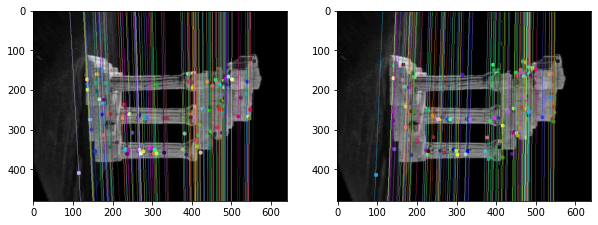

In [12]:
#question 4
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


im1 = cv.imread('templeSparseRing/'+im1_fn,0)
im2 = cv.imread('templeSparseRing/'+im2_fn,0) 
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
im5,im6 = drawlines(im1,im2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
im3,im4 = drawlines(im1,im2,lines2,pts2,pts1)
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(im5)
plt.subplot(122),plt.imshow(im3)
plt.show()